# Comprehensive Exploratory Data Analysis (EDA) for Open Food Facts Dataset

## Introduction

In this notebook, we will perform a detailed Exploratory Data Analysis (EDA) on the Open Food Facts dataset. The objective of this EDA is to explore the data, obtain useful statistics, and identify the data required to allow an ML model to extract the information in a product’s nutritional table using product images as the input. This step will be focused on data analysis and does not involve any model development.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from collections import Counter
import dask.dataframe as dd
from sklearn.decomposition import PCA
from PIL import Image
import requests
from io import BytesIO
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn style for plots
%matplotlib inline
sns.set_theme(style="whitegrid")

## Step 1: Data Loading and Initial Overview

### 1.1 Loading the Dataset

We begin by loading the dataset to understand its structure and content.

In [4]:
# Load the dataset
file_path = '../../data/raw/en.openfoodfacts.org.products.csv'

df = pd.read_csv(file_path, sep='\t',engine='python', quoting=csv.QUOTE_NONE)

# Display the first few rows
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1692101569,2023-08-15T12:12:49Z,digg,1.707748e+09,2024-02-12T14:25:39Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000000207025004,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1656948610,2022-07-04T15:30:10Z,1656948613,2022-07-04T15:30:13Z,kiliweb,1.707864e+09,2024-02-13T22:43:38Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1682646029,2023-04-28T01:40:29Z,isabel626,1.707844e+09,2024-02-13T17:00:47Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1654250311,2022-06-03T09:58:31Z,1654270474,2022-06-03T15:34:34Z,quentinbrd,1.707742e+09,2024-02-12T12:49:37Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,kiliweb,1.707490e+09,2024-02-09T14:47:36Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# get some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370309 entries, 0 to 3370308
Columns: 206 entries, code to acidity_100g
dtypes: float64(132), int64(2), object(72)
memory usage: 5.2+ GB


In [9]:
print("Data Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())

Data Shape: (3370309, 206)

Column Names: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'last_modified_by', 'last_updated_t', 'last_updated_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'ingredients_tags', 'ingredients_analysis_tags', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutrition_data', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore

### 1.2 Initial Data Overview

We'll get an overview of the dataset, including its size, data types, and the presence of missing values.

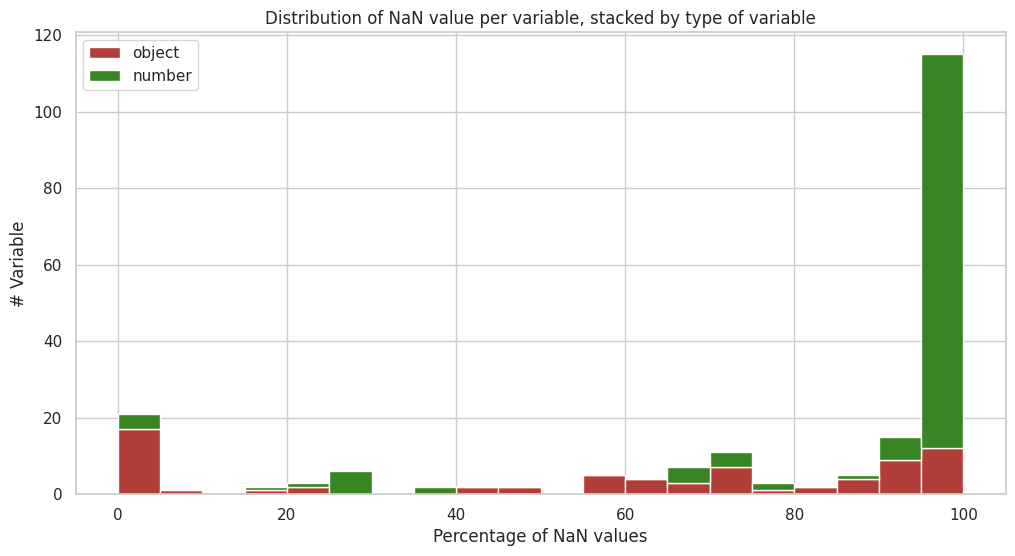

In [119]:
# Distribution of missing values per variable, stacked by type of variable
nan_counts_object_vars = df.select_dtypes('object').isnull().sum() / df.shape[0] * 100
nan_counts_number_vars = df.select_dtypes('number').isnull().sum() / df.shape[0] * 100

pd.DataFrame({'object': nan_counts_object_vars, 'number': nan_counts_number_vars}) \
  .plot.hist(stacked=True, bins=20, figsize=(12, 6), color=['#B13E38', '#398524'])

plt.xlabel('Percentage of NaN values')
plt.ylabel('# Variable')
plt.title('Distribution of NaN value per variable, stacked by type of variable')
plt.show()

In [120]:
# Overview of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.info()

# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values_percent = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percent})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data.sort_values(by='Percentage', ascending=False)


Dataset contains 3370309 rows and 206 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370309 entries, 0 to 3370308
Columns: 206 entries, code to acidity_100g
dtypes: float64(132), int64(2), object(72)
memory usage: 5.2+ GB


,Missing Values,Percentage
cities,3370309,100.000000
allergens_en,3370309,100.000000
additives,3370309,100.000000
nutrition-score-uk_100g,3370307,99.999941
elaidic-acid_100g,3370302,99.999792
glycemic-index_100g,3370301,99.999763
chlorophyl_100g,3370300,99.999733
water-hardness_100g,3370298,99.999674
erucic-acid_100g,3370298,99.999674
caproic-acid_100g,3370294,99.999555


In the range 0-95% of missing values, we have variables for macronutrients and the fats first breakdown level and the most current minerals and vitamins. We are missing starch, polyols for the first carbohydrates breakdown level; casein and serum-proteins for proteins

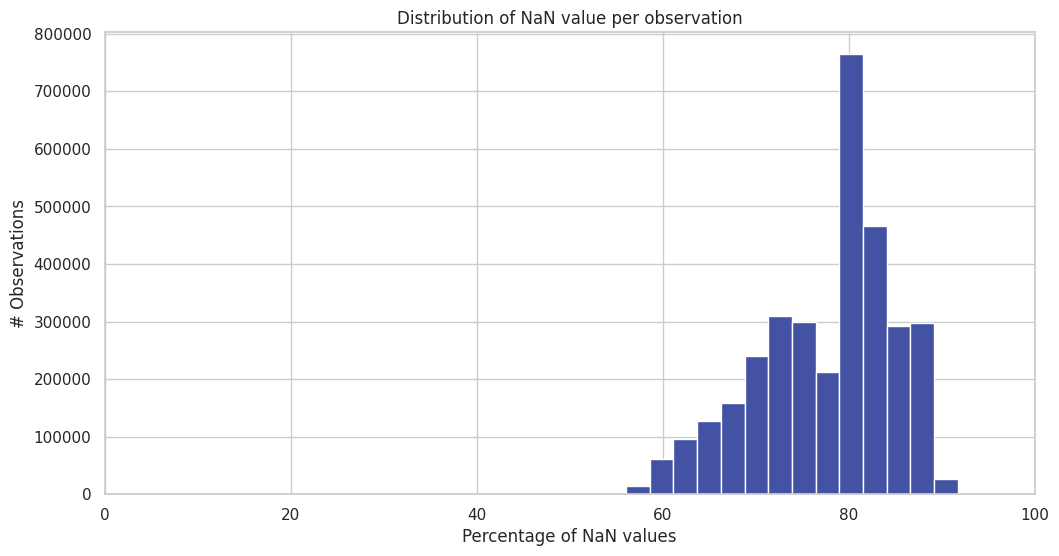

In [121]:
# Distribution of missing values per observation
nan_counts_obs = df.isnull().sum(axis=1) / df.shape[1] * 100
nan_counts_obs.hist(bins=20, figsize=(12, 6), color=['#4352a2'])

plt.xlim((0, 100))
plt.xlabel('Percentage of NaN values')
plt.ylabel('# Observations')
plt.title('Distribution of NaN value per observation')
plt.show()

Concerning missing values per observation, it is interesting to see this huge spike around 80% missing values.

In [122]:
nrows, ncols = df.shape

# Drop observations with no data (safe cleaning)
df.dropna(how='all', inplace=True)

# Drop variables with no data (safe cleaning)
empty_variables = df.columns[df.isnull().sum() == df.shape[0]]
df.dropna(how='all', axis=1, inplace=True)

# Remove duplicates observations
duplicates_count = df.duplicated().sum()
df.drop_duplicates(inplace=True)

print('Number of empty observations dropped: {}'.format(nrows - df.shape[0]))
print('Number of empty variables dropped: {}'.format(len(empty_variables)))
print('Variables dropped:\n{}'.format(empty_variables))
print('Number of duplicates dropped: {}'.format(duplicates_count))
print('\nDataset dimensions: {}'.format(df.shape))

Number of empty observations dropped: 0
Number of empty variables dropped: 3
Variables dropped:
Index(['cities', 'allergens_en', 'additives'], dtype='object')
Number of duplicates dropped: 0

Dataset dimensions: (3370309, 203)


In [ ]:
df.to_parquet('../../data/processed/df_no_duplicates_20240815.parquet', engine='pyarrow', compression='snappy')

## Step 2: Detailed Analysis of Columns

Given the wide variety of columns, we'll categorize them into general information, tags, ingredients, miscellaneous data, and nutritional facts. The selection of relevant columns will be justified based on the specific objective of building an ML model.

In [123]:
# Increase the default number of rows displayed by pandas before truncation
pd.options.display.max_rows = 200

In [16]:
# Get summary for object variables
df.describe(include='object').T

,count,unique,top,freq
code,3370309,3368113,8722700628927,3
url,3370309,3368367,http://world-en.openfoodfacts.org/product/3596...,2
creator,3370305,29528,kiliweb,1892549
created_datetime,3370309,3081189,2020-04-23T17:22:07Z,28
last_modified_datetime,3370309,2719116,2021-05-01T12:41:26Z,117
last_modified_by,3269146,35999,kiliweb,575013
last_updated_datetime,3347128,761053,2024-02-13T18:12:20Z,98
product_name,3195909,1984711,Miel,1856
abbreviated_product_name,26598,23953,150,18
generic_name,161894,118119,Pâtes alimentaires de qualité supérieure,418


In [68]:
# Get summary for numerical variables only
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
created_t,3363750.0,1.608083e+09,7.249930e+07,1.328021e+09,1.559200e+09,1.616743e+09,1.663694e+09,1.723701e+09
last_modified_t,3363750.0,1.659530e+09,4.941725e+07,1.353582e+09,1.629539e+09,1.672443e+09,1.697723e+09,1.723701e+09
last_updated_t,3340609.0,1.710278e+09,5.109467e+06,1.705496e+09,1.707631e+09,1.707829e+09,1.707889e+09,1.723701e+09
serving_quantity,776263.0,1.574668e+28,1.387374e+31,0.000000e+00,2.930000e+01,6.200000e+01,1.240000e+02,1.222357e+34
additives_n,976034.0,1.943796e+00,2.812277e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.900000e+01
nutriscore_score,1128737.0,8.823848e+00,8.813421e+00,-1.500000e+01,1.000000e+00,9.000000e+00,1.500000e+01,4.000000e+01
nova_group,898294.0,3.326476e+00,1.021725e+00,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
ecoscore_score,831913.0,4.909806e+01,2.506843e+01,-3.000000e+01,3.100000e+01,4.900000e+01,7.100000e+01,1.250000e+02
product_quantity,1000168.0,8.067496e+04,7.999880e+07,0.000000e+00,1.417476e+02,2.551457e+02,5.000000e+02,8.000546e+10
unique_scans_n,1073445.0,2.941386e+00,1.015909e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.109000e+03


#### Incoherent values

We will drop observations with incoherent values. We could decide to replace negative values by 0 but given the nature of the project in which everyone can contribute, observations with incoherent data are probably bad entries (and we have also more than enough data).

In [124]:
# Drop observations with facts that have negative values
obs_with_negative_facts = (df.loc[:, 'fat_100g':'cocoa_100g'] < 0).any(axis=1)
df.drop(df[obs_with_negative_facts].index, inplace=True)

# Drop observations with facts that have value greater than 100g
obs_with_facts_gt_100 = (df.loc[:, 'fat_100g':'cocoa_100g'] > 100).any(axis=1)
df.drop(df[obs_with_facts_gt_100].index, inplace=True)


print('Facts min value: {}'.format(df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'min'].min()))
print('Facts max value: {}'.format(df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'max'].max()))
print('Dataset shape: {}'.format(df.shape))

Facts min value: 0.0
Facts max value: 100.0
Dataset shape: (3363750, 203)


We will drop observations with incoherent values. We could decide to replace negative values by 0 but given the nature of the project in which everyone can contribute, observations with incoherent data are probably bad entries

In [ ]:
# Drop observations with facts that have negative values
obs_with_negative_facts = (df.loc[:, 'fat_100g':'cocoa_100g'] < 0).any(axis=1)
df.drop(df[obs_with_negative_facts].index, inplace=True)

# Drop observations with facts that have value greater than 100g
obs_with_facts_gt_100 = (df.loc[:, 'fat_100g':'cocoa_100g'] > 100).any(axis=1)
df.drop(df[obs_with_facts_gt_100].index, inplace=True)


print('Facts min value: {}'.format(df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'min'].min()))
print('Facts max value: {}'.format(df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'max'].max()))
print('Dataset shape: {}'.format(df.shape))

Facts min value: 0.0
Facts max value: 100.0
Dataset shape: (3363750, 203)


### 2.1 General Information

**Selected Columns:**
- `product_name`: Essential for identifying the product.
- `brands`: Important for understanding brand-specific patterns in nutritional information.
- `categories`: Critical for grouping products and identifying category-specific nutritional traits.
- `countries`: Useful for geographic analysis and potential regional variations in nutrition.
- `quantity`: May influence the nutritional content per 100g.

These columns provide essential metadata about the products, which can influence nutritional content and image analysis.

In [18]:
# Analyze general information columns
general_info_columns = ['product_name', 'brands', 'categories', 'countries', 'quantity']
df_general_info = df[general_info_columns]
df_general_info.describe(include='all').T

,count,unique,top,freq
product_name,3195909,1984711,Miel,1856
brands,1896602,312209,Carrefour,22856
categories,1480041,221078,Snacks,33784
countries,3345640,17610,France,468270
quantity,1064315,57676,1pcs,48103


### 2.2 Tags

**Selected Columns:**
- `packaging_tags`: The packaging could influence how easily nutritional information is visible in images.
- `brands_tags`: Helps in normalizing brand names and dealing with inconsistencies.
- `categories_tags`: Provides normalized categories which are useful for feature engineering.
- `labels_tags`: Could indicate specific health-related claims that might be relevant to nutritional content.
- `origins_tags`: Indicates the origin of ingredients, which might correlate with nutritional variations.

**Justification:** Tags provide a normalized and detailed view of product characteristics, which are important for both clustering similar products and understanding variations in nutritional content.

In [17]:
# Analyze tag columns
tag_columns = ['packaging_tags', 'brands_tags', 'categories_tags', 'labels_tags', 'origins_tags']
df_tags = df[tag_columns]
df_tags.describe(include='all').T

,count,unique,top,freq
packaging_tags,380604,49092,en:plastic,45573
brands_tags,1896455,239580,carrefour,23985
categories_tags,1480039,139628,en:snacks,34979
labels_tags,992136,104536,en:no-gluten,78423
origins_tags,136934,16106,en:france,29755


### 2.3 Ingredients

**Selected Columns:**
- `ingredients_text`: A detailed list of ingredients, which is directly related to the nutritional content.
- `traces_tags`: Information about traces of allergens, which might correlate with specific nutritional elements.

**Justification:** Ingredients are directly linked to nutritional content, and understanding the composition can help in predicting the presence of certain nutrients.

In [89]:
# Analyze ingredient columns
ingredient_columns = ['ingredients_text', 'traces_tags', 'categories_en']
df_ingredients = df[ingredient_columns]
df_ingredients.describe(include='all').T

,count,unique,top,freq
ingredients_text,976024,837700,Poulet,528
traces_tags,187338,15665,en:nuts,18239
categories_en,1476926,139046,Snacks,34946


### 2.5 Nutritional Facts

**Selected Columns:**
- `energy-kcal_100g`, `fat_100g`, `saturated-fat_100g`, `carbohydrates_100g`, `sugars_100g`, `fiber_100g`, `proteins_100g`, `salt_100g`: Core nutritional values that are directly linked to the model’s objective.
- `vitamin-a_100g`, `vitamin-c_100g`, `calcium_100g`, `iron_100g`: Specific micronutrients that could be relevant depending on the product category.

These columns contain the nutritional information that the ML model will ultimately predict from images. These are the core features around which the model will be built.

In [187]:
# Analyze nutritional columns
nutritional_columns = [
    'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
    'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'energy_100g', 'sodium_100g', 'polyols_100g',
    'trans-fat_100g','serum-proteins_100g', 'casein_100g'
]
df_nutrition = df[nutritional_columns]
df_nutrition.describe().T

,count,mean,std,min,25%,50%,75%,max
energy-kcal_100g,2480566.0,4.603788e+10,6.412975e+13,-53.0,103.00000,256.00000,398.000000,1.000000e+17
fat_100g,2503319.0,1.357943e+01,1.745961e+01,0.0,0.90000,7.00000,21.000000,1.000000e+02
saturated-fat_100g,2417917.0,5.019663e+00,7.720863e+00,0.0,0.10000,1.80000,7.000000,1.000000e+02
carbohydrates_100g,2506366.0,2.783858e+01,2.765585e+01,0.0,3.57000,15.50000,52.000000,1.000000e+02
sugars_100g,2449037.0,1.272440e+01,1.913443e+01,0.0,0.60000,3.57000,16.400000,1.000000e+02
fiber_100g,1167709.0,3.378308e+00,6.023143e+00,0.0,0.00000,1.70000,4.000000,1.000000e+02
proteins_100g,2507808.0,9.153944e+00,1.081848e+01,0.0,1.50000,6.20000,13.000000,1.000000e+02
salt_100g,2177680.0,1.355788e+00,4.406486e+00,0.0,0.10000,0.60000,1.400000,1.000000e+02
vitamin-a_100g,220268.0,2.496971e-02,1.215742e+00,0.0,0.00000,0.00000,0.000107,1.000000e+02
vitamin-c_100g,224489.0,3.500537e-02,9.070832e-01,0.0,0.00000,0.00000,0.004600,1.000000e+02


In [178]:
print('Number of observations: {}'.format(df_nutrition.shape[0]))

Number of observations: 3363750


In [188]:
def drop_observations_with_incoherent_breakdown(df, col_total, col_breakdown_start, col_breakdown_end, epsilon):
    breakdown_total  = df.loc[:, col_breakdown_start:col_breakdown_end].sum(axis=1)
    condition_filter = breakdown_total > (df[col_total] * (1 + epsilon))
    df.drop(df[condition_filter].index, inplace=True)

epsilon = 0.1  # tolerence for rounding error and protocol error measure 

# Carbohydrates: remove observations with sum of carbohydrates breakdown greater than the carbohydrates total (with tolerence)
drop_observations_with_incoherent_breakdown(df_nutrition, 
                                            col_total = 'carbohydrates_100g', 
                                            col_breakdown_start = 'sugars_100g', 
                                            col_breakdown_end = 'polyols_100g', 
                                            epsilon = epsilon)

# Fats: remove observations with sum of fats breakdown greater than the fats total (with tolerence)
drop_observations_with_incoherent_breakdown(df_nutrition, 
                                            col_total = 'fat_100g', 
                                            col_breakdown_start = 'saturated-fat_100g', 
                                            col_breakdown_end = 'trans-fat_100g', 
                                            epsilon = epsilon)

# Proteins: remove observations with sum of proteins breakdown greater than the proteins total (with tolerence)
drop_observations_with_incoherent_breakdown(df_nutrition, 
                                            col_total = 'proteins_100g', 
                                            col_breakdown_start = 'casein_100g', 
                                            col_breakdown_end = 'serum-proteins_100g', 
                                            epsilon = epsilon)

print('Number of observations: {}'.format(df_nutrition.shape[0]))

Number of observations: 871812


## Step 3: Exploratory Data Analysis (EDA)

### 3.1 Descriptive Statistics and Initial Insights

Descriptive statistics give an overview of the distributions of various features, allowing us to understand the central tendencies, variability, and potential outliers. This is essential for ensuring that the dataset is suitable for ML model development.

In [21]:
# Descriptive statistics for all relevant columns
df_clean = df[general_info_columns + tag_columns + ingredient_columns + nutritional_columns]
df_clean.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_name,3195909,1984711,Miel,1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brands,1896602,312209,Carrefour,22856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categories,1480041,221078,Snacks,33784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countries,3345640,17610,France,468270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,1064315,57676,1pcs,48103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
packaging_tags,380604,49092,en:plastic,45573,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brands_tags,1896455,239580,carrefour,23985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categories_tags,1480039,139628,en:snacks,34979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
labels_tags,992136,104536,en:no-gluten,78423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origins_tags,136934,16106,en:france,29755,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Get the top occurencies 
def get_top_occurencies(df, cols, n=10):
    count = df.groupby(cols).size().sort_values(ascending=False)
    count_percent = round(count / df.shape[0] * 100, 2)
    return pd.DataFrame({'count': count, 'count %': count_percent}).head(n)

# Utility function: 
# Get the top occurencies containing a regexp/string
def get_top_occurencies_containing(df, col, value, n=10):
    occurences = get_top_occurencies(df, col, df.shape[0])
    return occurences[occurences.index.str.contains(r'{}'.format(value))].head(n)

In [39]:
# Get the top contributors
get_top_occurencies(df, 'creator', n=10)

,count,count %
creator,,
kiliweb,1891254,56.22
openfoodfacts-contributors,195489,5.81
foodvisor,172295,5.12
usda-ndb-import,169622,5.04
org-database-usda,134445,4.00
prepperapp,101363,3.01
foodless,73594,2.19
smoothie-app,68576,2.04
macrofactor,53368,1.59


We see that half of the data come from KILIWEB is a french startup who develop the Yuka app that implements the OpenFoodFacts API. Also, there are other contibutors, like anonymous community contributors and US deparment of agriculture.

#### States of the observations

In [63]:
# Get some examples of states_tags values
get_top_occurencies(df, 'states_tags', 10)

,count,count %
states_tags,,
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-to-be-completed,en:brands-to-be-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded",416982,12.40
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded",173650,5.16
"en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-to-be-completed,en:brands-to-be-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-to-be-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded",130855,3.89
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-uploaded",129474,3.85
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-uploaded",110321,3.28
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-completed,en:brands-to-be-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-uploaded",106254,3.16
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded",102129,3.04
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-completed,en:brands-to-be-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded",76809,2.28
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-comp

### 3.2 Correlation Analysis

Correlation analysis helps in identifying relationships between different nutritional facts and other relevant variables. This analysis is crucial for feature selection, as highly correlated features might be redundant or informative for feature engineering.

In [179]:
nutritional_columns = [
    'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
    'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'energy_100g', 'sodium_100g'
]

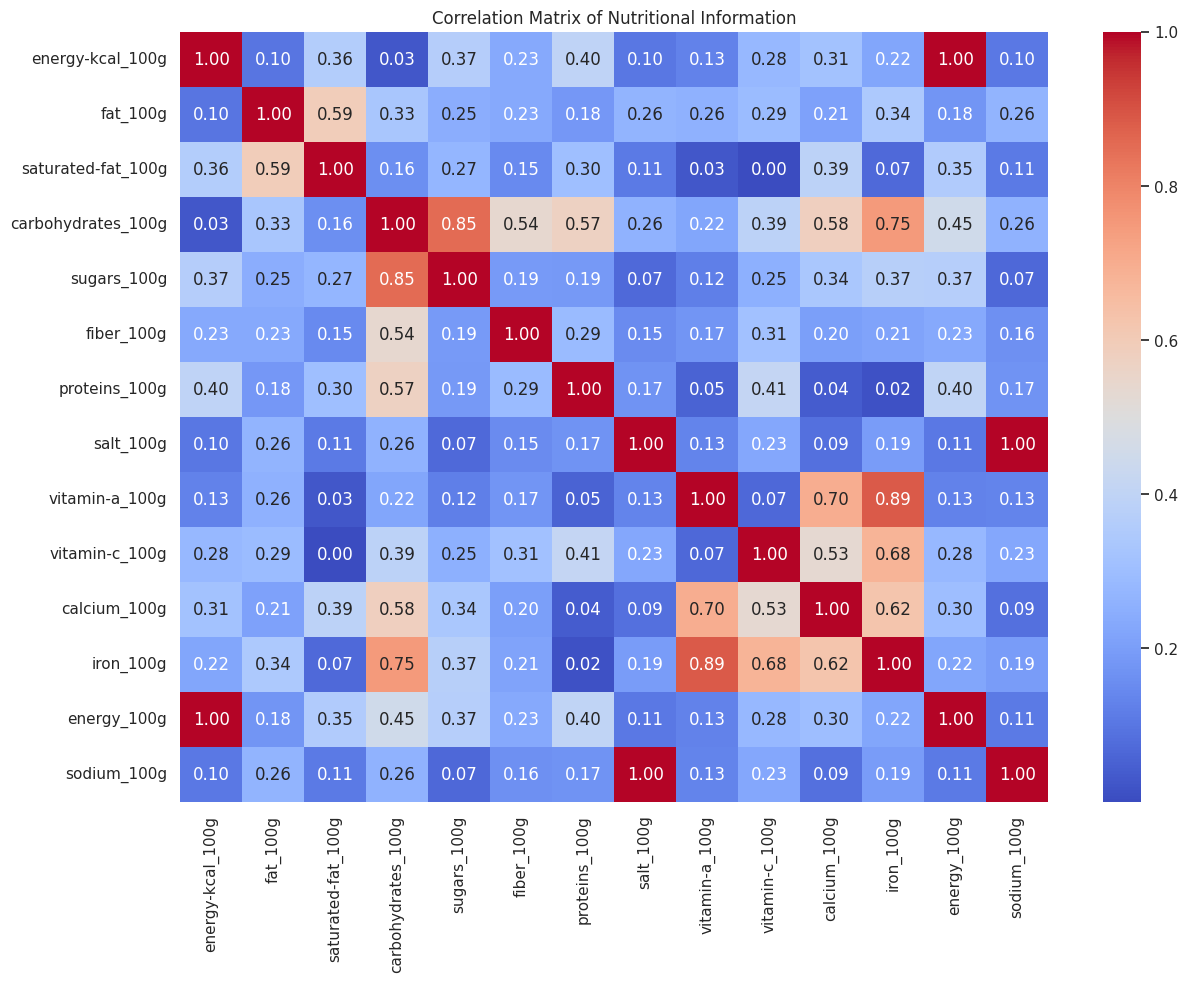

In [157]:
# Correlation matrix for nutritional information
corr_matrix = df_nutrition[nutritional_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Nutritional Information')
plt.show()

This correlation matrix helps identify relationships between different nutritional components. Highly correlated nutrients might indicate that certain types of foods are rich or poor in specific sets of nutrients together.

By analyzing the correlation matrix, you can identify and remove features that contribute little to no additional information, helping to focus on the most relevant characteristics when analyzing images. if fat_100g and saturated-fat_100g are highly correlated, focusing on one might suffice to capture the information relevant to fat content in images.

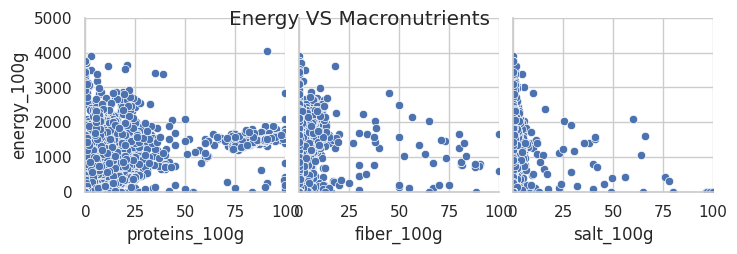

In [205]:
x_vars = [
    'proteins_100g',
    'fiber_100g',
    'salt_100g']

y_vars = ['energy_100g']

# Obtain scatter plots of the energy versus each macronutrients for all groups of food
g = sns.pairplot(df_nutrition, kind='scatter', x_vars=x_vars, y_vars=y_vars)
g.figure.suptitle('Energy VS Macronutrients')
g.set(xlim=(0, 100))
g.set(ylim=(0, 5000))
plt.show()

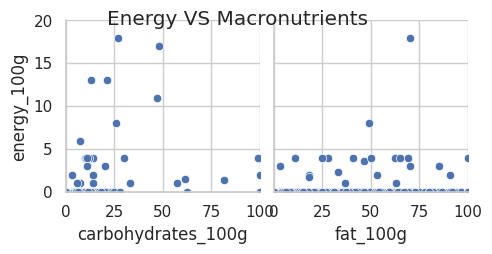

In [204]:

x_vars = [
    'carbohydrates_100g',
    'fat_100g',
    ]

y_vars = ['energy_100g']

# Obtain scatter plots of the energy versus each macronutrients for all groups of food
g = sns.pairplot(df_nutrition, kind='scatter', x_vars=x_vars, y_vars=y_vars)
g.figure.suptitle('Energy VS Macronutrients')
g.set(xlim=(0, 100))
g.set(ylim=(0, 20))
plt.show()

### 3.3 Distribution Analysis

Understanding the distribution of key variables like categories, and brands helps in identifying any biases or imbalances in the data, which can influence model performance.

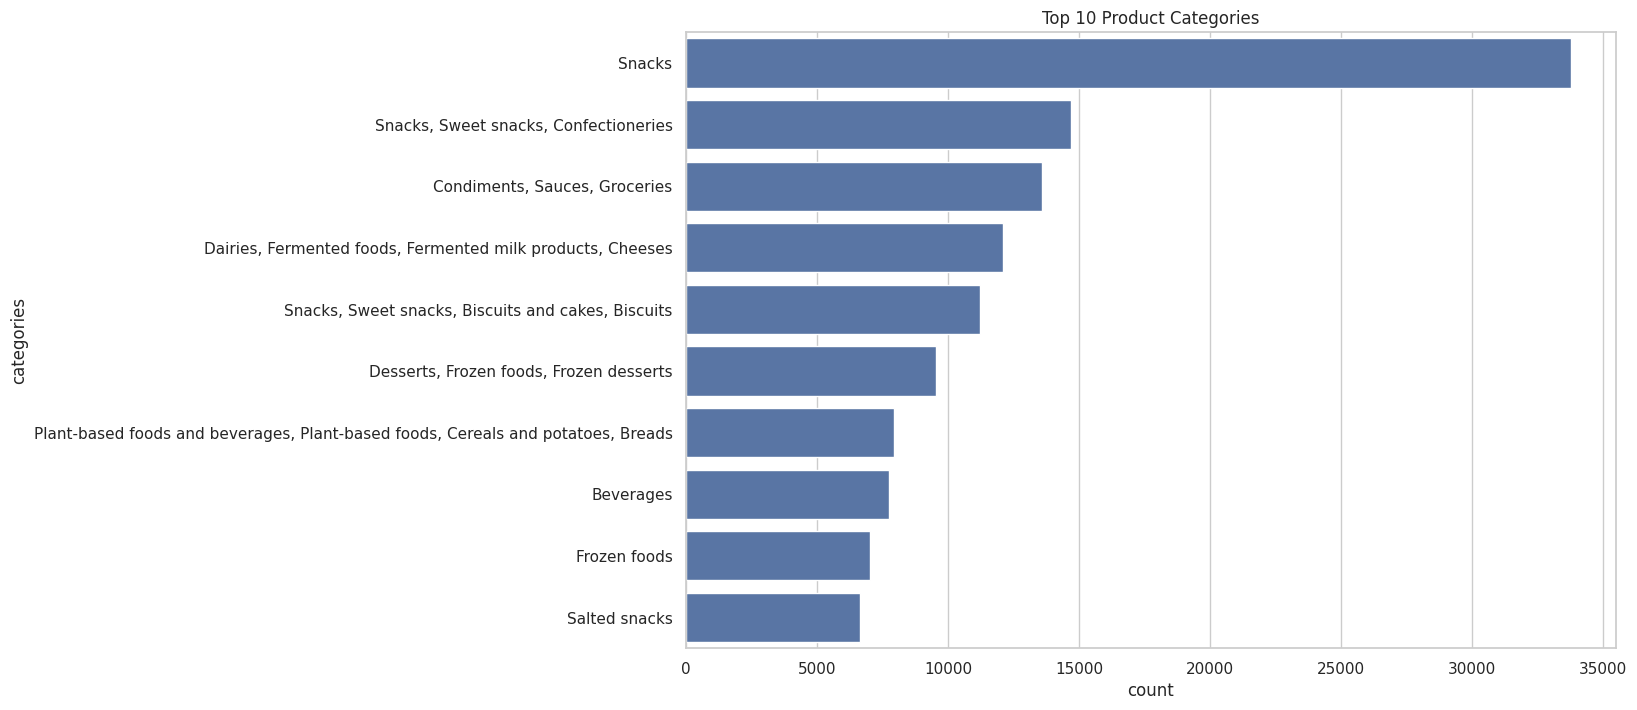

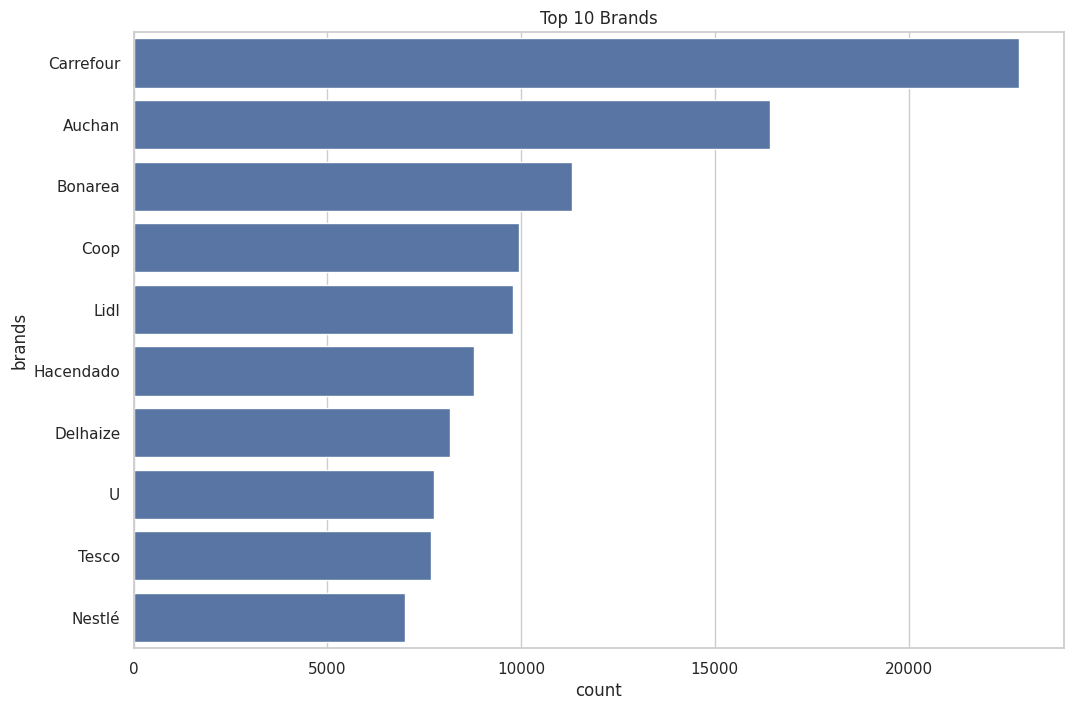

In [44]:
# Distribution of top categories and brands
plt.figure(figsize=(12, 8))
sns.countplot(y=df_clean['categories'], order=df_clean['categories'].value_counts().index[:10])
plt.title('Top 10 Product Categories')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y=df_clean['brands'], order=df_clean['brands'].value_counts().index[:10])
plt.title('Top 10 Brands')
plt.show()

### 3.4 Outliers Analysis


Deeply analyze numerical columns, identify outliers, and understand the distribution of values.

In [126]:
# Statistical summary of numerical columns
df_nutrition.describe().T
# Detect outliers using IQR
Q1 = df_nutrition.quantile(0.25)
Q3 = df_nutrition.quantile(0.75)
IQR = Q3 - Q1
outliers = (df_nutrition < (Q1 - 1.5 * IQR)) | (df_nutrition > (Q3 + 1.5 * IQR))
outliers

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,energy_100g,sodium_100g
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370304,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3370305,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3370306,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3370307,False,False,False,False,True,False,False,False,False,False,False,False,False,False


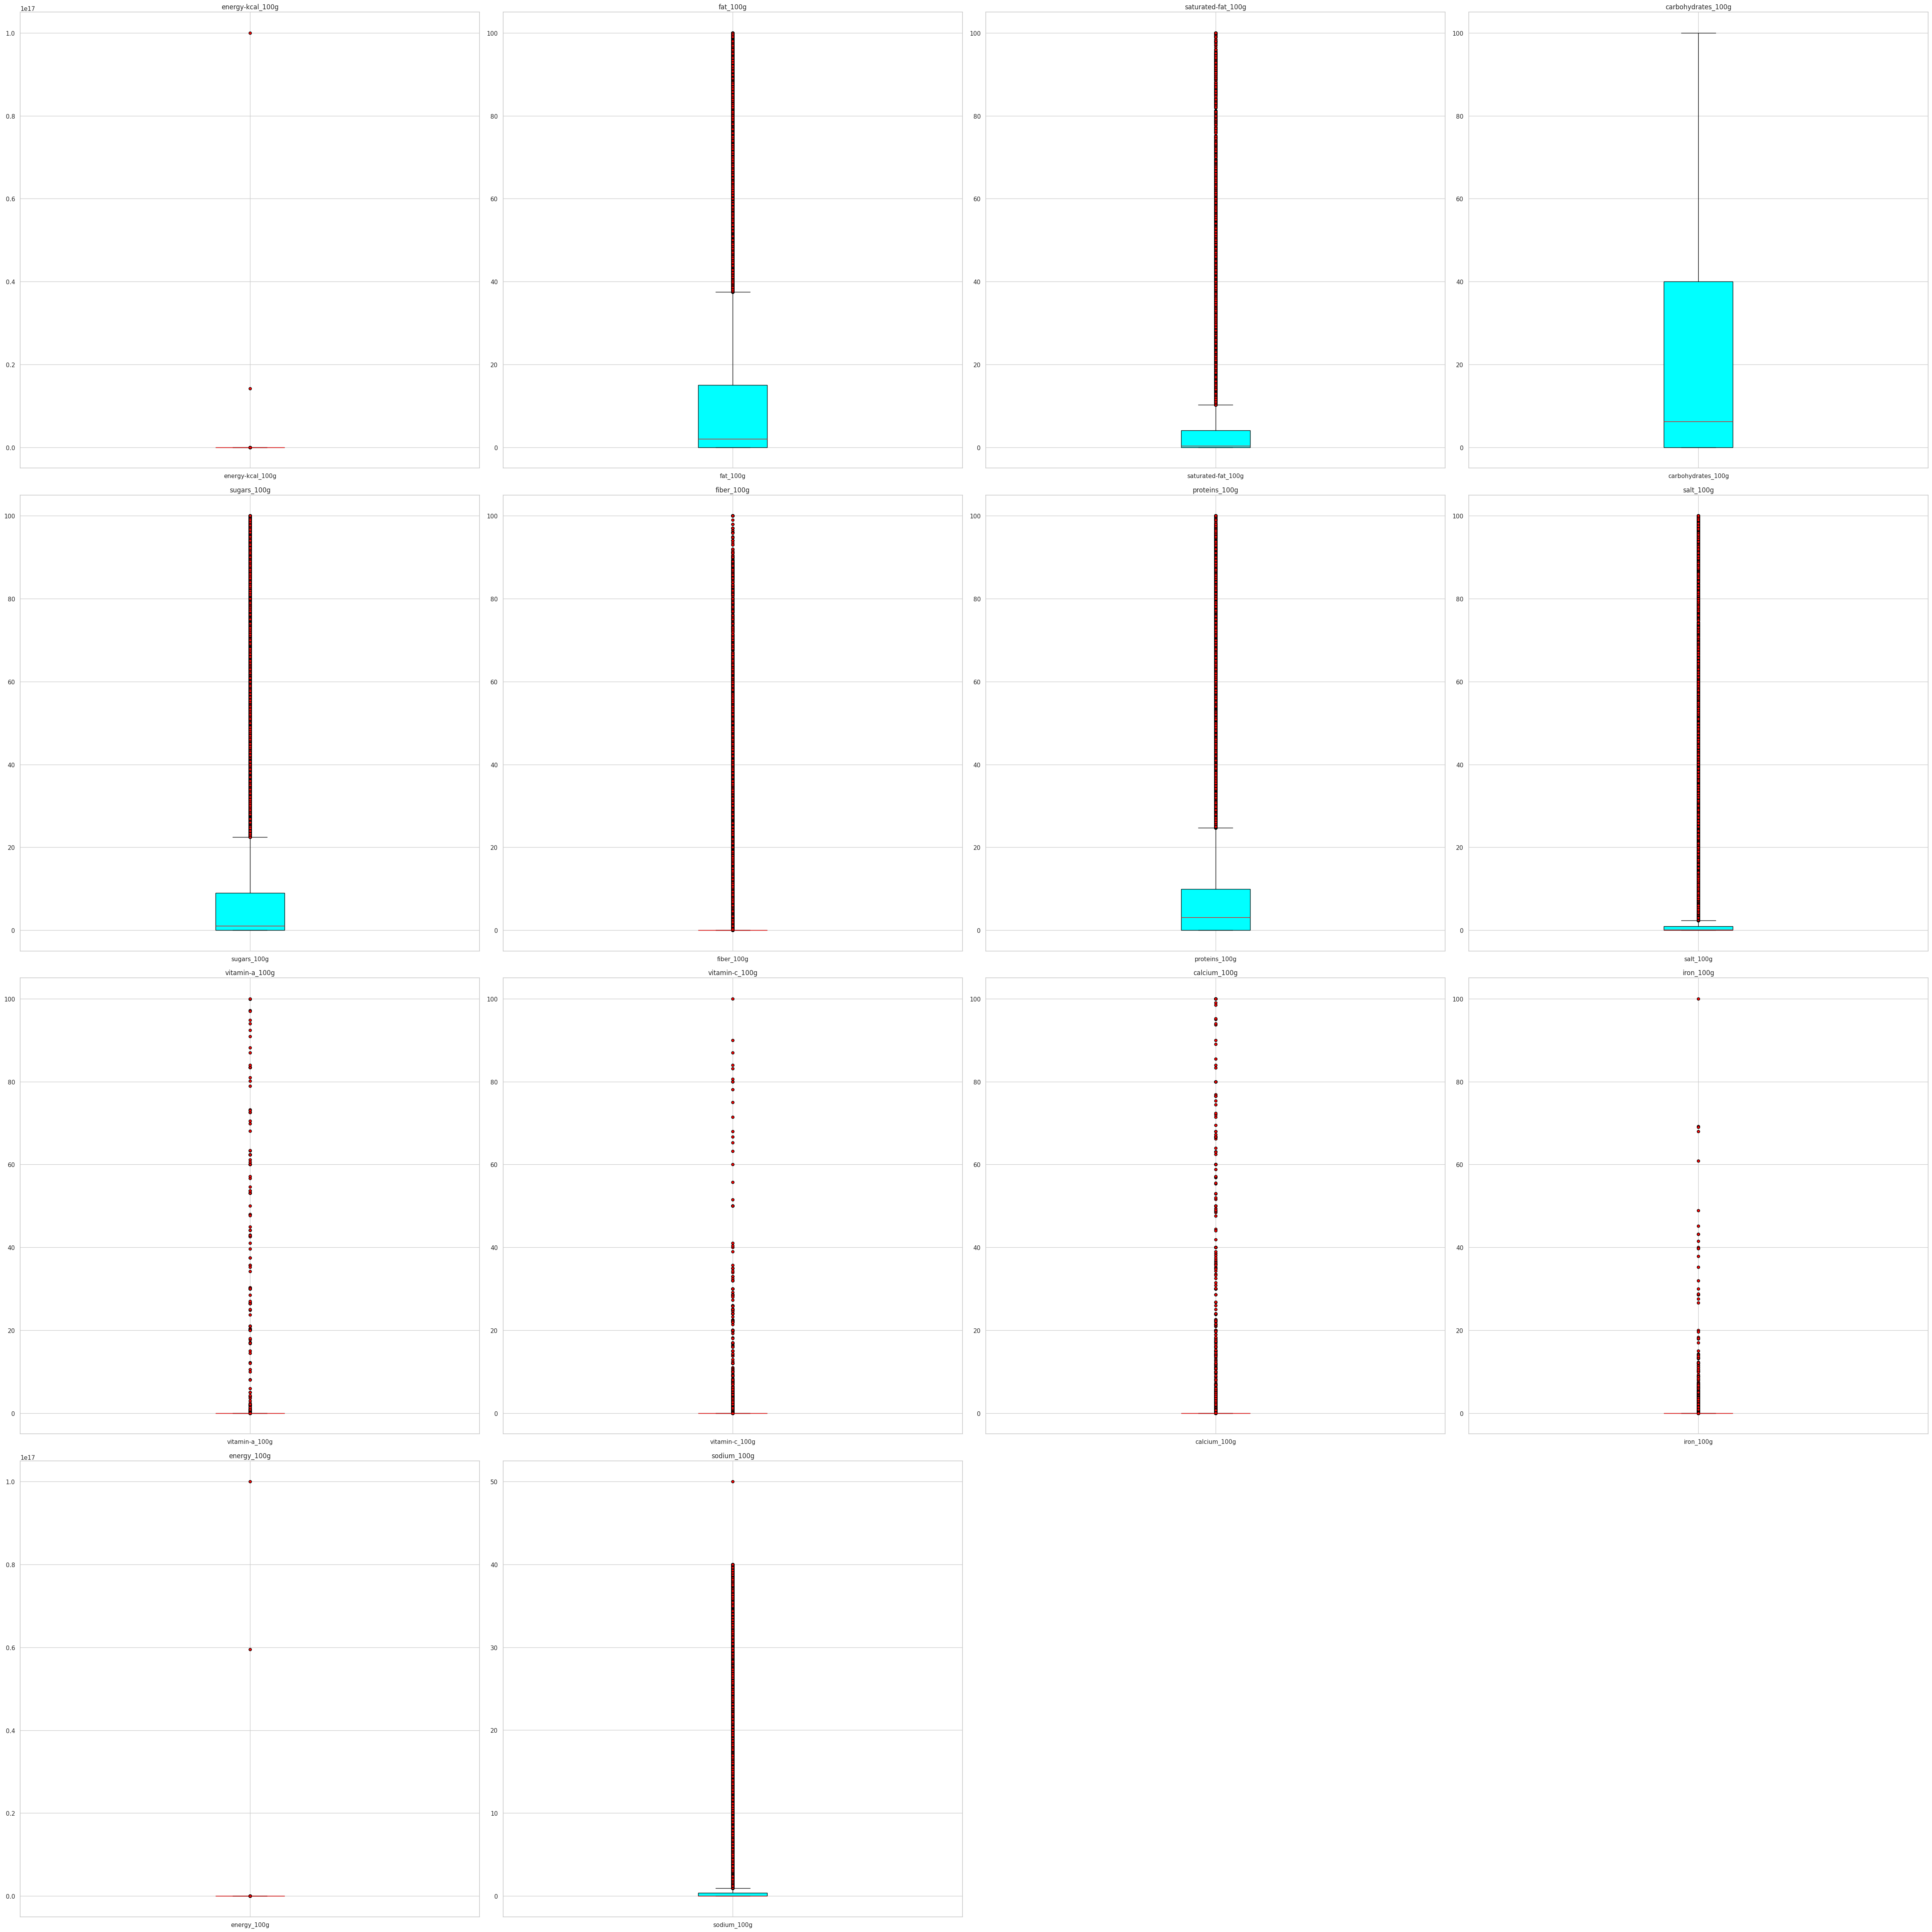

In [139]:
plt.figure(figsize=(50, 50))
for i, column in enumerate(df_nutrition.columns, 1):
    plt.subplot(4, 4, i)
    plt.boxplot(df_nutrition[column], vert=True, patch_artist=True, boxprops=dict(facecolor='cyan', color='black'),
                medianprops=dict(color='red'), whiskerprops=dict(color='black'), capprops=dict(color='black'),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none', markeredgecolor='black'))
    plt.title(f'{column}')
    plt.xticks([1], [column])

plt.tight_layout()
plt.show()


Most columns display a heavy presence of outliers, suggesting that the dataset has a high degree of variability in nutritional content. This might be expected in a dataset that spans a wide variety of food products.
The presence of extreme values (as seen in some of the energy-related plots) could be due to data entry errors or specific types of food products with exceptionally high energy content. These should be reviewed to ensure data quality.

### 3.5 PCA


Use PCA to reduce the dimensionality of numerical features and analyze the variance captured.

In [207]:
df_nutrition.fillna(value=0, inplace=True)

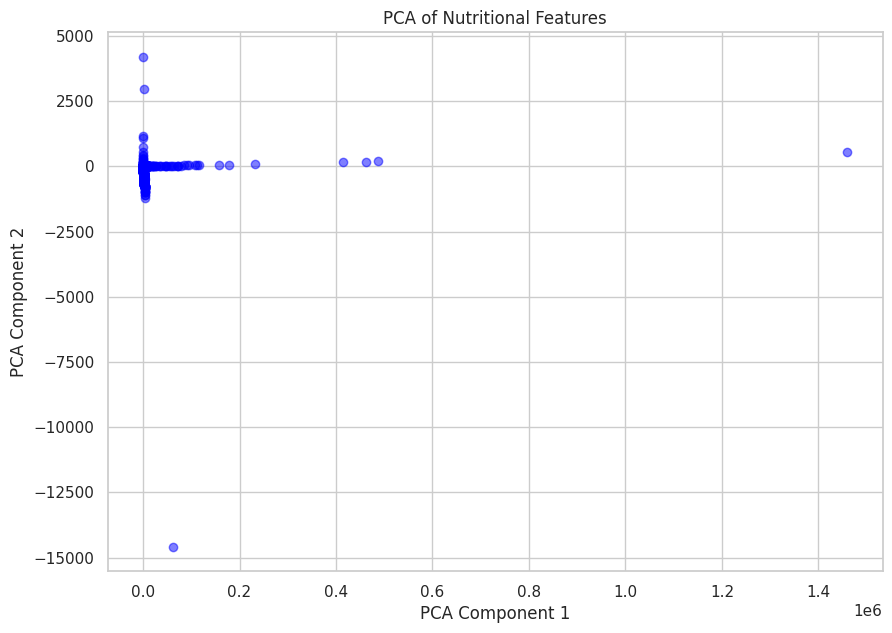

In [210]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_nutrition)
df_nutrition['pca_1'] = pca_result[:, 0]
df_nutrition['pca_2'] = pca_result[:, 1]

# Plotting the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df_nutrition['pca_1'], df_nutrition['pca_2'], c='blue', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Nutritional Features')
plt.show()

The majority of the data points are clustered around the origin (0, 0), which indicates that for most samples, the variance captured by these two principal components is relatively low.
There are a few outliers, particularly in the extreme negative and positive directions along both PCA Component 1 and PCA Component 2. This suggests that there are certain samples in the dataset with significantly different nutritional compositions compared to the rest.

## Step 4: Image Data Analysis

The image data is crucial for the ML model since the model's objective is to predict nutritional information from images. Analyzing the availability, quality, and completeness of image data is necessary to ensure that the dataset is sufficient for training a robust model.

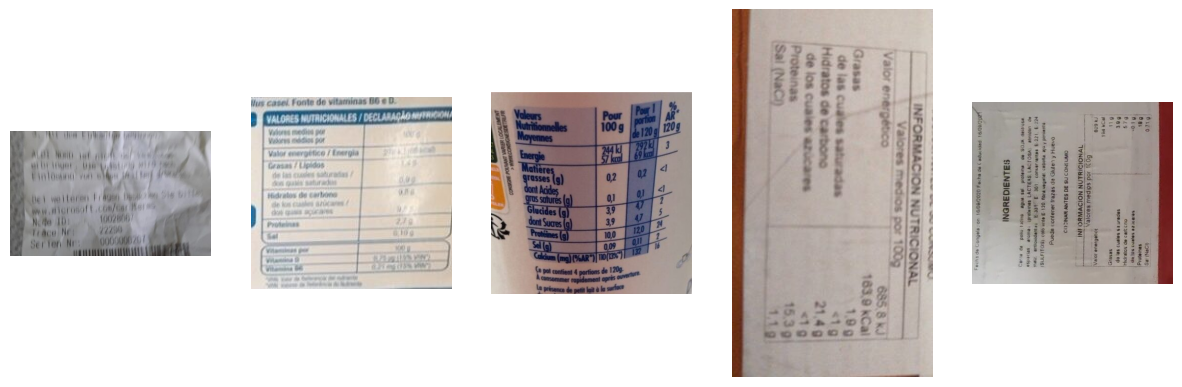

In [217]:
# Function to display images from URLs
def display_images(image_urls, n_images=5):
    plt.figure(figsize=(15, 10))
    for i, url in enumerate(image_urls[:n_images]):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Example usage: Display first 5 product images
image_urls = df['image_nutrition_url'].dropna().tolist()  # or 'image_nutrition_url', 'image_ingredients_url'
display_images(image_urls, n_images=5)

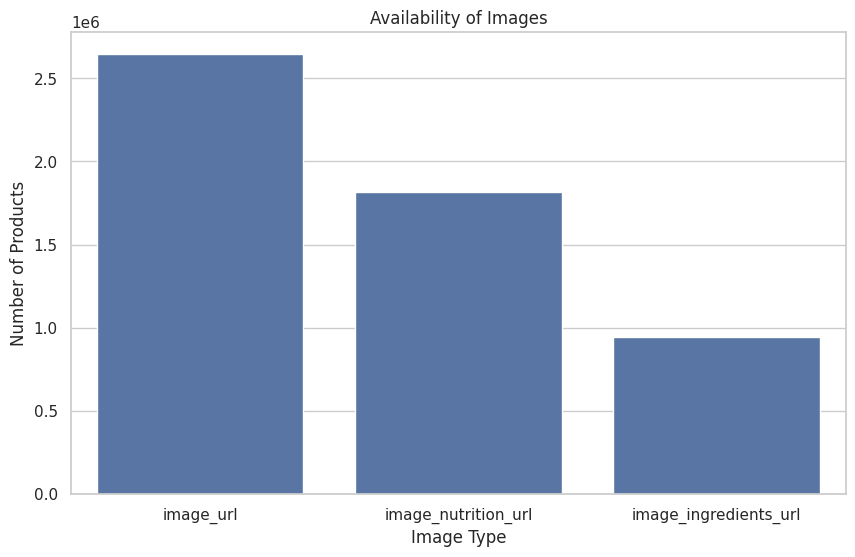

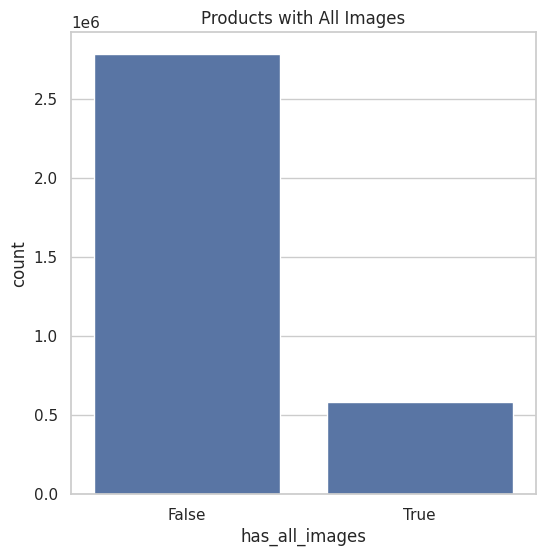

In [49]:
# Check availability of images
image_columns = ['image_url', 'image_nutrition_url', 'image_ingredients_url']
image_availability = df[image_columns].notnull().sum()

# Visualize the availability of images
plt.figure(figsize=(10, 6))
sns.barplot(x=image_availability.index, y=image_availability.values)
plt.title('Availability of Images')
plt.xlabel('Image Type')
plt.ylabel('Number of Products')
plt.show()

# Analysis of products with all necessary images
df['has_all_images'] = df[image_columns].notnull().all(axis=1)
plt.figure(figsize=(6, 6))
sns.countplot(x='has_all_images', data=df_clean)
plt.title('Products with All Images')
plt.show()


As the use case is extract nutrition information, we analyze this kind of image

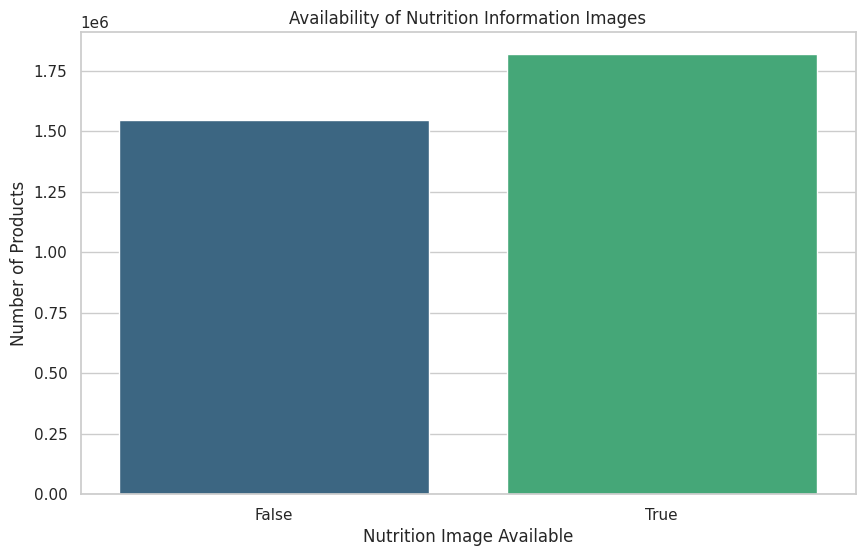

In [218]:
# Check the availability of nutrition images
nutrition_image_availability = df['image_nutrition_url'].notnull().sum()

# Visualize the availability of nutrition images
plt.figure(figsize=(10, 6))
sns.countplot(x=df['image_nutrition_url'].notnull(), palette='viridis')
plt.title('Availability of Nutrition Information Images')
plt.xlabel('Nutrition Image Available')
plt.ylabel('Number of Products')
plt.show()


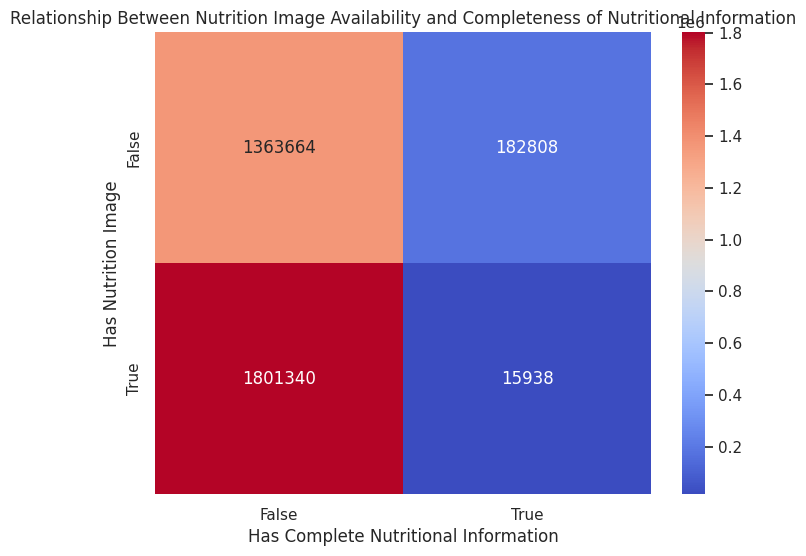

In [220]:
# Define the nutritional columns
nutritional_columns = [
    'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
    'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 
    'energy_100g', 'sodium_100g'
]

# Check if nutritional information is complete
df['has_nutritional_info'] = df[nutritional_columns].notnull().all(axis=1)

# Analyze relationship between having a nutritional image and completeness of nutritional information
df['has_nutrition_image'] = df['image_nutrition_url'].notnull()

# Create a crosstab to see the relationship
nutrition_image_relationship = pd.crosstab(df['has_nutrition_image'], df['has_nutritional_info'])

# Visualize the crosstab
plt.figure(figsize=(8, 6))
sns.heatmap(nutrition_image_relationship, annot=True, cmap='coolwarm', fmt='d')
plt.title('Relationship Between Nutrition Image Availability and Completeness of Nutritional Information')
plt.xlabel('Has Complete Nutritional Information')
plt.ylabel('Has Nutrition Image')
plt.show()

<Figure size 1200x800 with 0 Axes>

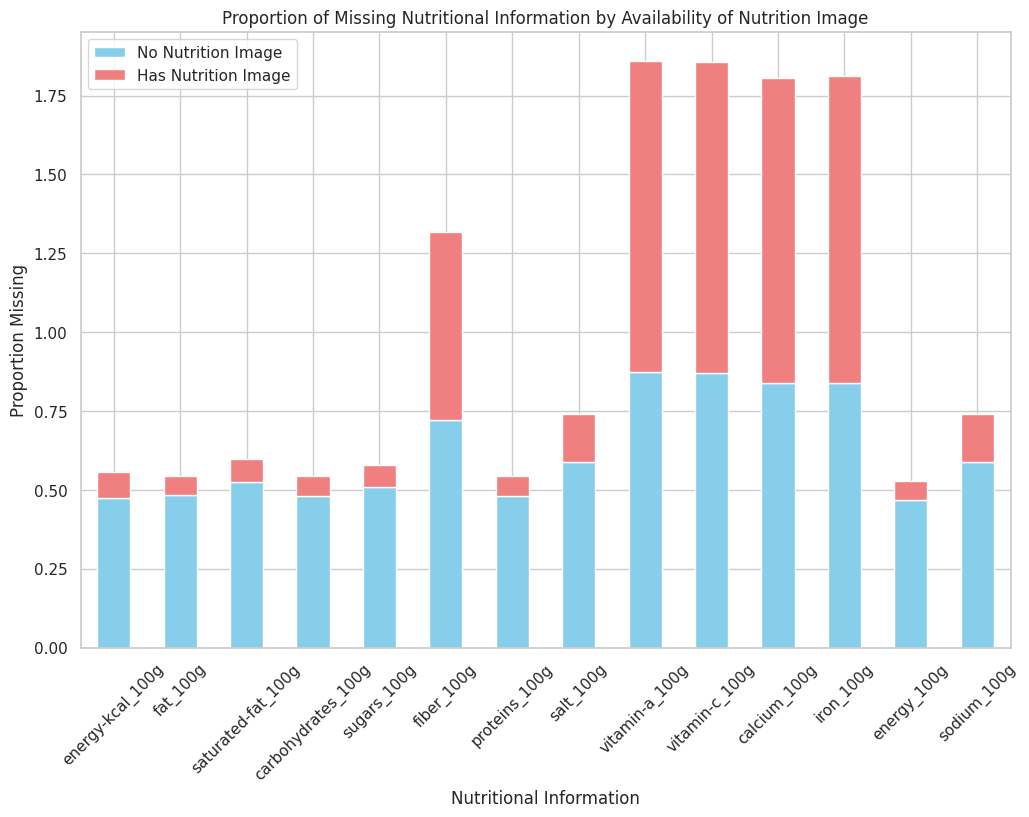

In [221]:
# Calculate the proportion of missing values for each nutritional column
missing_nutrition_proportions = df.groupby('has_nutrition_image')[nutritional_columns].apply(lambda x: x.isnull().mean())

# Visualize the proportion of missing nutritional data
plt.figure(figsize=(12, 8))
missing_nutrition_proportions.T.plot(kind='bar', figsize=(12, 8), stacked=True, color=['skyblue', 'lightcoral'])
plt.title('Proportion of Missing Nutritional Information by Availability of Nutrition Image')
plt.xlabel('Nutritional Information')
plt.ylabel('Proportion Missing')
plt.legend(['No Nutrition Image', 'Has Nutrition Image'])
plt.xticks(rotation=45)
plt.show()


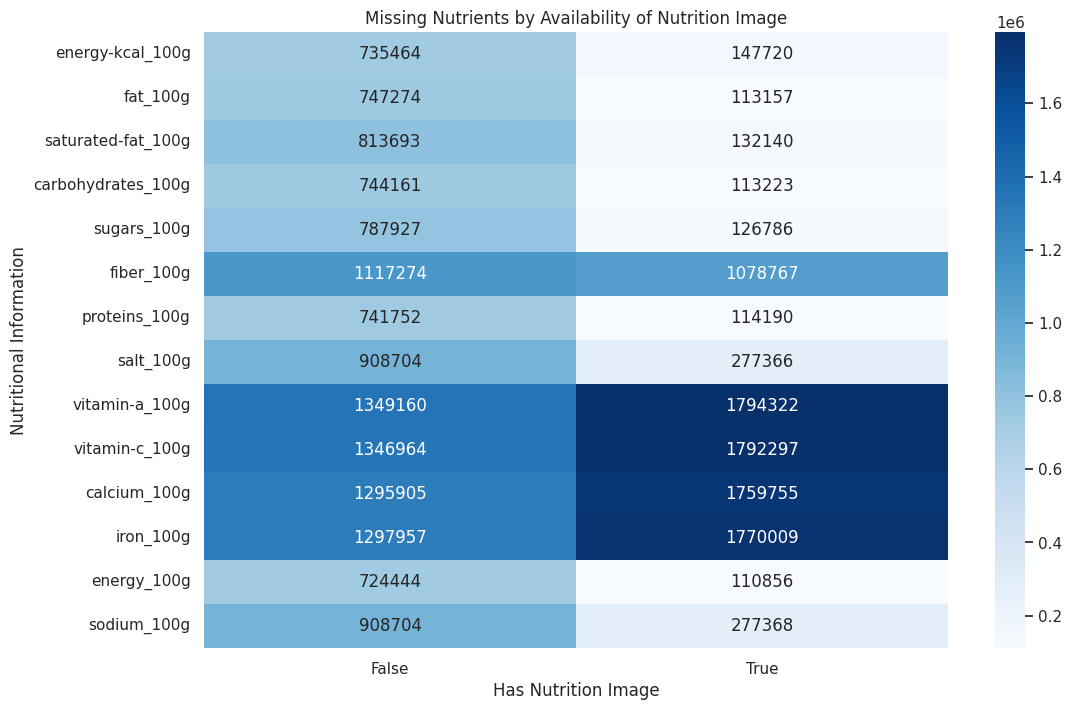

In [223]:
# Analyzing specific nutrients missing by image availability
missing_specific_nutrient = df.groupby('has_nutrition_image')[nutritional_columns].apply(lambda x: x.isnull().sum())

# Visualize missing specific nutrients
plt.figure(figsize=(12, 8))
sns.heatmap(missing_specific_nutrient.T, annot=True, cmap='Blues', fmt='d')
plt.title('Missing Nutrients by Availability of Nutrition Image')
plt.xlabel('Has Nutrition Image')
plt.ylabel('Nutritional Information')
plt.show()

Through these analyses, you can understand whether having a nutrition image contributes to better completeness of nutritional information in your dataset, and which specific nutrients tend to be more or less well-represented when such images are available. This will help you identify potential gaps or areas where improvements could be made in your image-based nutritional extraction process.

## Step 5: Additional Feature Analysis

Analyzing additional features like labels, origins, and additives is important for understanding their potential impact on nutritional content. These features might also be useful for stratifying the dataset or as additional inputs to the ML model.

In [9]:
df['origins_tags'].value_counts()

origins_tags
en:france                                                                                                                                    29755
en:italy                                                                                                                                      8409
en:spain                                                                                                                                      5633
en:european-union                                                                                                                             5628
en:germany                                                                                                                                    4509
                                                                                                                                             ...  
en:africa,en:bolivia,en:latin-america,en:non-european-union,en:paraguay                                  

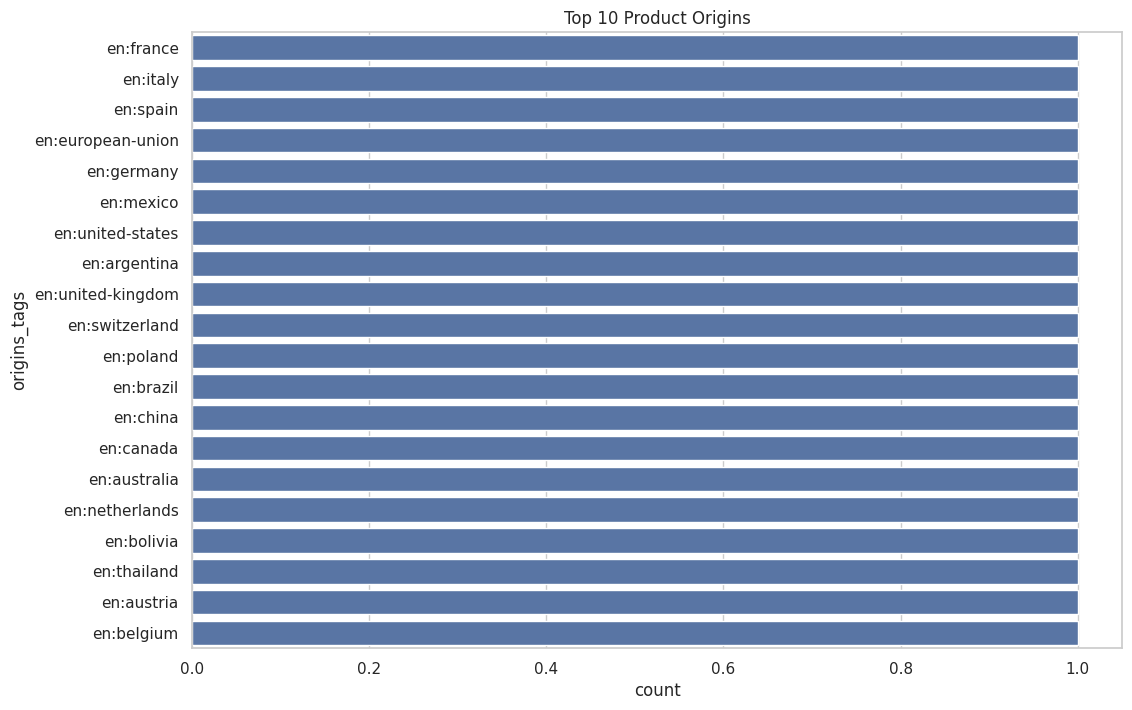

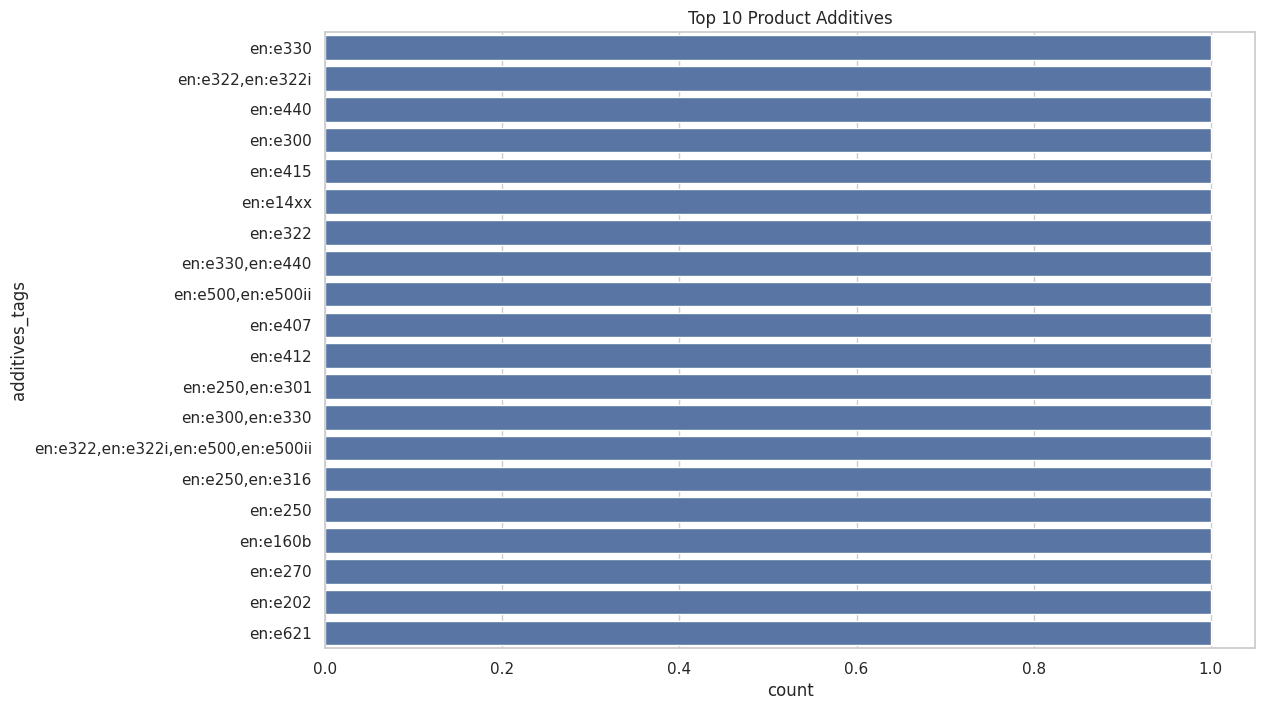

In [8]:
# Top origins
plt.figure(figsize=(12, 8))
sns.countplot(y=df['origins_tags'].value_counts().index[:20])
plt.title('Top 10 Product Origins')
plt.show()

# Top additives
plt.figure(figsize=(12, 8))
sns.countplot(y=df['additives_tags'].value_counts().index[:20])
plt.title('Top 10 Product Additives')
plt.show()

We will see the top occurencies of ingredients text. 

In [76]:
# Get some ingredients raw data
get_top_occurencies(df, 'ingredients_text', n=100)

,count,count %
ingredients_text,,
Poulet,528,0.02
"Carbonated water, natural flavor.",477,0.01
Almonds.,395,0.01
"Spring water, co2, natural flavors.",335,0.01
Miel,334,0.01
Extra virgin olive oil.,322,0.01
Bœuf,297,0.01
"Semolina (wheat), durum flour (wheat), niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid.",295,0.01
Honey,283,0.01


In [79]:
# Analyze text-based columns
text_columns = ['product_name', 'brands', 'categories', 'labels_tags', 'origins_tags']
df[text_columns].describe()

for col in text_columns:
    all_words = ' '.join(df[col].dropna()).split()
    word_freq = Counter(all_words)
    print(f"Top 10 words in {col}:")
    print(word_freq.most_common(10))
    print("\n")

Top 10 words in product_name:
[('de', 356609), ('&', 82896), ('au', 65130), ('-', 57668), ('di', 53681), ('à', 46583), ('Organic', 39705), ('Chocolate', 37355), ('et', 37283), ('aux', 33593)]


Top 10 words in brands:
[('&', 33358), ('Inc.', 31305), ('La', 28758), ('Carrefour', 28427), ('de', 22841), ('Foods', 20283), ('Bio', 18814), ('Auchan', 18560), ('Le', 16488), ('Coop', 13021)]


Top 10 words in categories:
[('de', 922257), ('et', 589820), ('à', 485768), ('and', 414166), ('Aliments', 385269), ('base', 375806), ('Produits', 293108), ('Plant-based', 290313), ('foods,', 265773), ('dérivés,', 228889)]


Top 10 words in labels_tags:
[('en:no-gluten', 78315), ('en:green-dot', 62961), ('en:no-gmos,en:non-gmo-project', 39759), ('en:organic', 34132), ('en:vegetarian,en:vegan', 32640), ('en:no-preservatives', 21073), ('en:organic,en:eu-organic,fr:ab-agriculture-biologique', 18759), ('en:made-in-france', 15155), ('en:organic,en:eu-organic', 12870), ('en:organic,en:no-gmos,en:non-gmo-project

## Conclusion

This EDA has been extensive, covering all relevant columns in the dataset and justifying the selection of each feature based on its relevance to the goal of developing an ML model to extract nutritional information from product images. The analysis involved understanding the data distributions, correlations, and interactions, ensuring that the dataset is sufficiently clean and comprehensive for model training.

The careful selection of features, combined with a thorough analysis of both the nutritional and non-nutritional data, lays a solid foundation for the next steps in model development. The EDA process has ensured that all relevant aspects of the data are understood, and potential challenges are identified and addressed before moving forward.